# Introduction
Use *Forecasting Patient Volume and Resource Demand to Better Inform Nurse Staffing Decisions* by Schienker et al. to predict Average Daily Census (ADC, daily number of filled beds). This notebook shows the process of preparing the data, training and evaluating our models. Key metrics in our model selection are meeting our target error (under 15% MAPE) and adaptability in the forecast. If our error is low, but the forecast provides no insight into the fluctuations of patient volume, then the model is of little value.
### Problem Statement
Use 2 years worth of Daily Census data to forecast Average Daily Census (ADC) more accuractely.
### Experimental Procedure
- Exploratory Data Analysis: [EDA on Github.](https://github.com/cobrobrown/thinkful_course/blob/master/Final%20Capstone/Exploratory%20Data%20Analysis.ipynb) Explore the dataset in order to understand which models to use and how to transform the data into features.
- Feature engineering: Prepare the data for the machine learning pipeline. 
- Modeling: Randomly split the training data and run each model. Record training times for evaluation.
- Results: Compare predictions from each model using MAPE and adaptability.
- Evaluate: Weigh the strengths and weaknesses of each model. Choose a model to productionize.

In [2]:
# Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import time
# Modeling
import statsmodels.api as sm
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM,GRU,Dropout, TimeDistributed
import xgboost as xgb
from sklearn.linear_model import LinearRegression

Using TensorFlow backend.


In [3]:
df = pd.read_excel('AvgDailyCensusPerDept2Years.xlsx')
df.sort_values(by='EffectiveDAte',inplace=True)

# Exploratory Data Analysis
Follow along with [this notebook](https://github.com/cobrobrown/thinkful_course/blob/master/Final%20Capstone/Exploratory%20Data%20Analysis.ipynb) in order to dive deeper into the nature of our dataset. Below is an overview of the data, which picks out the PICU department as an example used throughout the rest of this notebook.

In [6]:
# look at PICUs ADC and average ADC per day
df_PICU = df[df['DepartmentName'] == "PICU"].reset_index(drop=True)
df_alldept = df.groupby(['EffectiveDAte']).mean()
# and PICU ADC and Total ADC
df_alldept_M = df.groupby(pd.Grouper(key='EffectiveDAte',freq='M')).mean()
df_PICU_M = df_PICU.groupby(pd.Grouper(key='EffectiveDAte',freq='M')).mean()

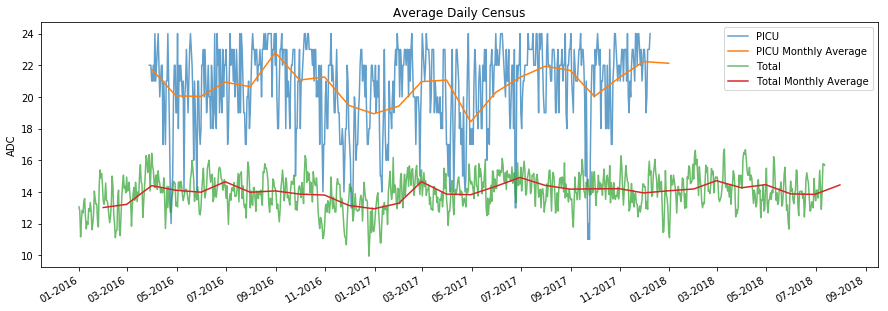

In [7]:
#plot ADC
plt.figure(figsize=(15,5))
plt.plot(df_PICU['EffectiveDAte'],df_PICU['AverageCensusCount'],label="PICU",alpha=.7)
plt.plot(df_PICU_M,label="PICU Monthly Average",alpha=1)
plt.plot(df_alldept,label="Total",alpha=.7)
plt.plot(df_alldept_M,label="Total Monthly Average",alpha=1)
plt.title("Average Daily Census")
plt.ylabel("ADC")
plt.legend()
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.show()

The Time Series shows PICU's daily and monthly ADC compared to that of all departments. There is a large variability and no signs of trends or seasonality. Note that the PICU time series covers almost 2 whole years or 21 months.

# Feature Engineering

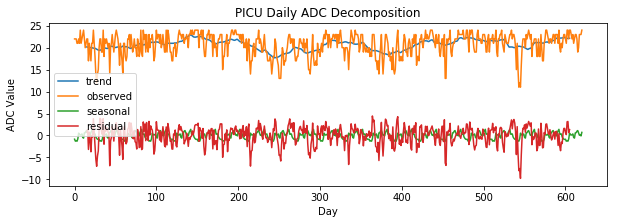

In [37]:
freq=30 # assume monthly frequency
s_PICU = sm.tsa.seasonal_decompose(df_PICU['AverageCensusCount'].values,freq=freq)
# look at trend, seasonal, resid and observed
plt.figure(figsize=(10,3))
plt.plot(s_PICU.trend,label="trend")
plt.plot(s_PICU.observed,label="observed")
plt.plot(s_PICU.seasonal,label="seasonal")
plt.plot(s_PICU.resid,label="residual")
plt.title("PICU Daily ADC Decomposition")
plt.ylabel("ADC Value")
plt.xlabel("Day")
plt.legend()
plt.show()

To further iterate the point above, there is some indication of a trend and seasonality, but residuals still plague the decomposition of the original signal. This time series is not simple to model and will require powerful machine learning algorithms to accurately forecast the target variable. Limited features are available, only previous values and the dates of records are given.
<br>Luckily, algorithms like ARIMA are able to take only a series as input and generate forecasts based on three parameters: p,q and d. 'p' controls the number of past values to consider, 'q' controls the number of difference terms to take, and 'd' controls the number of error terms to include. To find the order of each parameter we need to look at the difference series and ensure stationarity.

### ARIMA: Finding Order of (p,q,d)

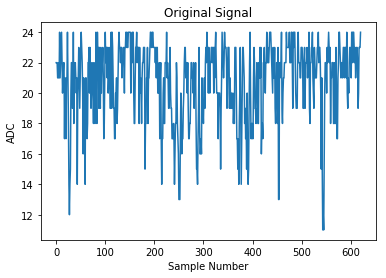

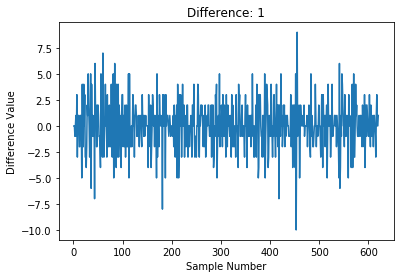

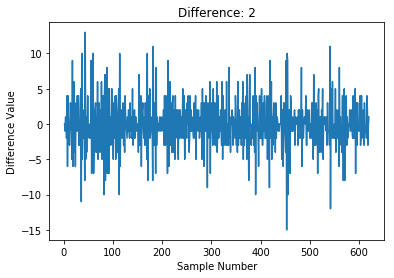

In [39]:
# find order of stationarity by plotting signals
plt.plot(range(len(df_PICU.index)),df_PICU["AverageCensusCount"])
plt.title("Original Signal")
plt.xlabel("Sample Number")
plt.ylabel("ADC")
plt.show()
# difference: 1
dif_1 = df_PICU['AverageCensusCount'] - df_PICU['AverageCensusCount'].shift()
plt.plot(range(len(dif_1)),dif_1)
plt.title("Difference: 1")
plt.xlabel("Sample Number")
plt.ylabel("Difference Value")
plt.show()
# difference: 2
dif_2 = dif_1 - dif_1.shift()
plt.plot(range(len(dif_2)),dif_2)
plt.title("Difference: 2")
plt.xlabel("Sample Number")
plt.ylabel("Difference Value")
plt.show()

Stationarity is a proprty of signals which have consistent means and variances throughout time.

The original signal is not stationary, so we look at the first few difference orders to get a stationary signal. The first two orders are stationary, so we'll include these orders in our parameter grid search for ARIMA.

Next we look at the partial autocorrelation of the differences signals. These plot will show us how to choose our p and q.

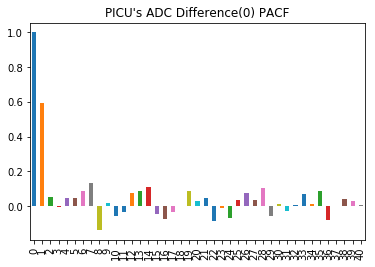

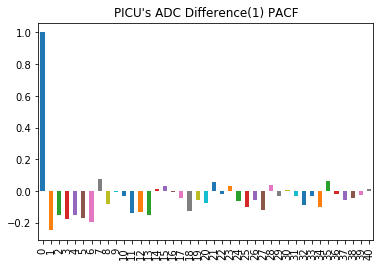

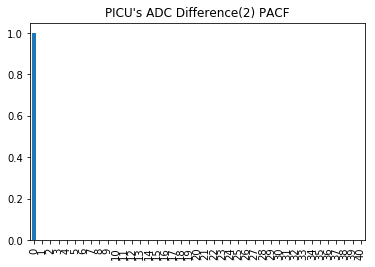

In [11]:
# look at (partial) autocorrelation of differenced signals
x_acf = pd.DataFrame()
x_acf['signal'] = pacf(df_PICU['AverageCensusCount'])
x_acf['signal'].plot(kind='bar')
plt.title("PICU's ADC Difference(0) PACF")
plt.show()
x_acf['dif_1'] = pacf(dif_1[1:])
x_acf['dif_1'].plot(kind='bar')
plt.title("PICU's ADC Difference(1) PACF")
plt.show()
x_acf['dif_2'] = pacf(dif_2[1:])
x_acf['dif_2'].plot(kind='bar')
plt.title("PICU's ADC Difference(2) PACF")
plt.show()

The partial autocorrelation plots for the previous series give us a list of parameters to try for p, our autoregressive term which tells us how many previous values to consider. The values that stand out above are 1,3,6,and 8.

Below is the summary of our best performing ARIMA model wht parameters (2,1,6).

                              ARIMA Model Results                               
Dep. Variable:     D.AverageCensusCount   No. Observations:                  620
Model:                   ARIMA(2, 1, 6)   Log Likelihood               -1325.518
Method:                         css-mle   S.D. of innovations              2.049
Date:                  Sun, 19 Aug 2018   AIC                           2671.035
Time:                          17:47:33   BIC                           2715.333
Sample:                               1   HQIC                          2688.254
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0023      0.006      0.348      0.728      -0.010       0.015
ar.L1.D.AverageCensusCount    -1.2163      0.159     -7.660      0.

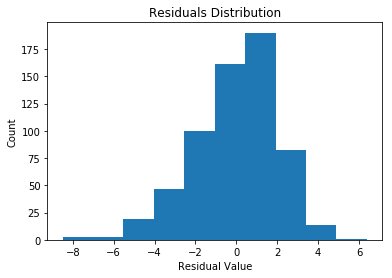

In [19]:
model = ARIMA(df_PICU['AverageCensusCount'], order=(2,1,6))
model_fit = model.fit()
print(model_fit.summary())
plt.hist(model_fit.resid)
plt.title("Residuals Distribution")
plt.xlabel("Residual Value")
plt.ylabel("Count")
plt.show()

After running a grid search on order values, the combination 2,1,6 for p,q, and d respectively show the lowest AIC score and normally distributed residuals. Notice that a few terms are not significant (where p values are higher than 0.05). This may hinder our model, nevertheless, it is the best form of ARIMA we have.

### Linear Models: Generating Features
Our linear models take an array of features and tunes the parameters of each feature to achieve the lowest error on the training data. Our features below were derived and explained in my [EDA here](https://github.com/cobrobrown/thinkful_course/blob/master/Final%20Capstone/Exploratory%20Data%20Analysis.ipynb).

In [40]:
# linear features
df_PICU_xgb = df_PICU[['EffectiveDAte','AverageCensusCount']].reset_index(drop=True)
df_PICU_xgb['year'] = df_PICU_xgb['EffectiveDAte'].dt.year
df_PICU_xgb['month'] = df_PICU_xgb['EffectiveDAte'].dt.month
df_PICU_xgb['dayofweek'] = df_PICU_xgb['EffectiveDAte'].dt.dayofweek
df_PICU_xgb['lpch_main_open'] = 0
df_PICU_xgb.loc[df_PICU_xgb["EffectiveDAte"] < '2017-12-09']['lpch_main_open'] = 1
offset=30
window=14
for i in range(len(df_PICU_xgb.index))[offset+window:]:
    win_range = df_PICU_xgb.loc[i-window-offset:i-offset,'AverageCensusCount']
    df_PICU_xgb.loc[i,'prev_mean'] = win_range.mean()
    df_PICU_xgb.loc[i,'prev_std'] = win_range.std()

### RNN Models: Making Tensors
The RNN models use the time series feature in a unique way. By providing a tensor of inputs, each with an increasing lag, the model is trained to take lagged values into account when forecasting. To build the lagged features, we can shift our original time series by any lag and concatenate it next to the original series.

In [41]:
# sequential split
def seq_split(df,window_size=7):
    X = df.copy()
    df_temp = df.copy()
    for i in range(window_size):
        X = pd.concat([df_temp.shift(i+1),X],axis=1)
    return X.dropna(axis=0)

In [43]:
test_size = 60
train_size = len(df_PICU.index) - test_size
window_size=7
df_PICU_train = seq_split(df_PICU['AverageCensusCount'][:train_size],window_size=window_size)
df_PICU_test = seq_split(df_PICU['AverageCensusCount'][train_size:],window_size=window_size)
X_PICU_train = df_PICU_train.iloc[:,:-1]
Y_PICU_train = df_PICU_train.iloc[:,-1]
X_PICU_test = df_PICU_test.iloc[:,:-1]
Y_PICU_test = df_PICU_test.iloc[:,-1]
# reshape for LSTM
X_PICU_train = np.reshape(X_PICU_train.values, (len(X_PICU_train), 1, X_PICU_train.shape[1]))
X_PICU_test = np.reshape(X_PICU_test.values, (len(X_PICU_test), 1, X_PICU_test.shape[1]))
print("Training X")
print(X_PICU_train[:5,0,:])
print("Training Y")
display(Y_PICU_train.head())

Training X
[[22. 22. 22. 21. 21. 22. 21.]
 [22. 22. 21. 21. 22. 21. 24.]
 [22. 21. 21. 22. 21. 24. 21.]
 [21. 21. 22. 21. 24. 21. 22.]
 [21. 22. 21. 24. 21. 22. 23.]]
Training Y


7     24
8     21
9     22
10    23
11    24
Name: AverageCensusCount, dtype: int64

By looking at the first 5 rows of the training data, we can see that each row of X contains the previous 7 days of ADC values ending in the corresponding row of Y for "today's" ADC value. When fed into the RNN architectures, these tensors will train the model how the previous 7 days ADC value influences today's ADC value.

# Modeling

### ARIMA

In [44]:
# setup arima
order = (2,1,6)
X_arima_train = df_PICU['AverageCensusCount'][:train_size]
Y_arima_test = df_PICU['AverageCensusCount'][train_size:]
arima_model = ARIMA(X_arima_train, 
                      order=order
                     )
arima_model_fit = arima_model.fit()

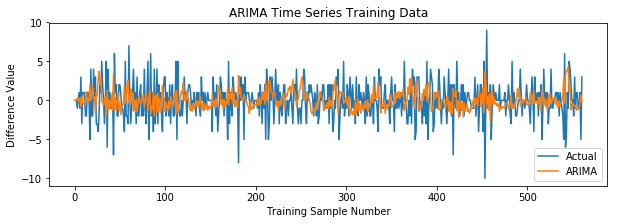

In [51]:
# in-sample predictions
arima_train_predict = arima_model_fit.predict(start=1,end=train_size)
# trained values
plt.figure(figsize=(10,3))
X_arima_dif_1 = X_arima_train - X_arima_train.shift()
plt.plot(range(len(X_arima_dif_1.index)),X_arima_dif_1,label="Actual")
plt.plot(range(len(arima_train_predict)),arima_train_predict,label="ARIMA")
plt.legend()
plt.title("ARIMA Time Series Training Data")
plt.xlabel("Training Sample Number")
plt.ylabel("Difference Value")
plt.show()

In [58]:
def plot_test_eval(Y_test,Y_pred,Y_res,model_name):
    print("ARIMA Error",np.mean(abs(Y_res)))
    #plot out-of-sample time series
    plt.plot(range(len(Y_test.index)),Y_test,label="Actual")
    plt.plot(range(len(Y_test.index)),Y_pred,label=model_name)
    plt.title(model_name+" Time Series Testing Data")
    plt.xlabel("Testing Sample Number")
    plt.ylabel("ADC")
    plt.legend()
    plt.show()
    # plot errors
    plt.scatter(Y_test,Y_res)
    plt.title(model_name+" Residuals")
    plt.xlabel("Ordered Testing Data ADC")
    plt.ylabel("Residual")
    plt.show()
    # histogram of errors
    plt.hist(Y_res)
    plt.title(model_name+" Distribution of Residuals")
    plt.ylabel("Count")
    plt.xlabel("Residual Value")
    plt.show()

ARIMA Error 1.7485271863345881


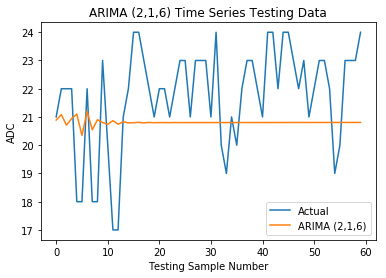

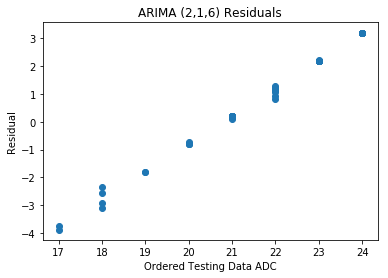

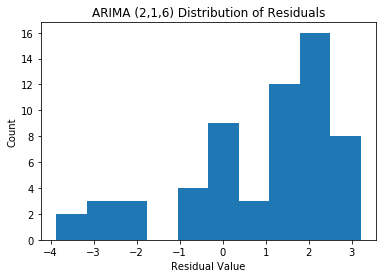

In [60]:
# out-of-sample forecast
arima_forecast,_,_ = arima_model_fit.forecast(test_size)
# error
arima_res = Y_arima_test.values - arima_forecast
plot_test_eval(Y_arima_test,arima_forecast,arima_res,"ARIMA (2,1,6)")

The model performs well with a Mean Absolute Error under 2.0 (our target value). However, from the time series forecast plot, we see that the model resorts to predicting the same value after 10 days. This may not be the best suited model for production given its weak long-term forecasting abilities. Also, note that the residuals are skewed to the right of 0.

### Linear Models

In [61]:
X_PICU_xgb = df_PICU_xgb[['year','month','dayofweek','lpch_main_open','prev_mean','prev_std']]
Y_PICU_xgb = df_PICU_xgb['AverageCensusCount']
# sequential train test split
X_PICU_xgb_train = X_PICU_xgb.iloc[X_PICU_xgb.index[:train_size]]
X_PICU_xgb_test = X_PICU_xgb.iloc[X_PICU_xgb.index[train_size:]]
Y_PICU_xgb_train = Y_PICU_xgb.iloc[Y_PICU_xgb.index[:train_size]]
Y_PICU_xgb_test = Y_PICU_xgb.iloc[Y_PICU_xgb.index[train_size:]]

In [62]:
# linear regression
lr_model = LinearRegression()
lr_features = ["prev_mean","prev_std","dayofweek","month","year","lpch_main_open"]
lr_X_train = X_PICU_xgb_train[lr_features].fillna(0)
lr_X_test = X_PICU_xgb_test[lr_features].fillna(0)
lr_model.fit(lr_X_train, Y_PICU_xgb_train)
print("Linear Regression R Squared",lr_model.score(lr_X_train,Y_PICU_xgb_train))

Linear Regression R Squared 0.04284135672660916


A very low R-squared score tells us that the linear regression model does not capture the same variance than is present in the target variable in the training data. With such a low score, it should stand that the linear model is either not complex enough to model the time series or there are not enough features which explain the variance in the target variable. For future research, we could try additional feature engineering or more complex linear models.

ARIMA Error 2.0656440741405593


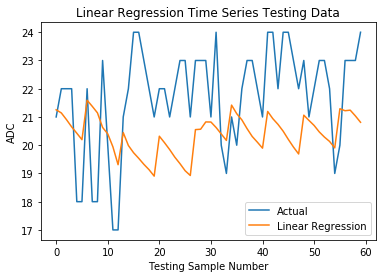

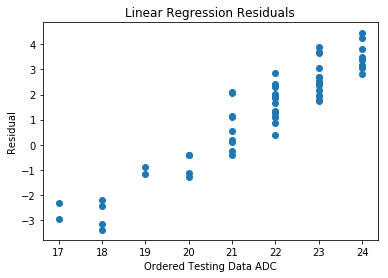

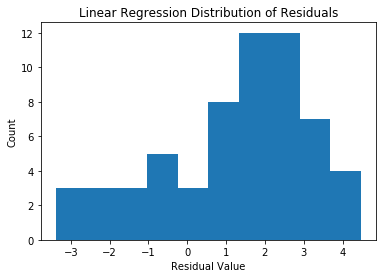

In [63]:
lr_pred = lr_model.predict(lr_X_test)
lr_res = Y_PICU_xgb_test-lr_pred
plot_test_eval(Y_PICU_xgb_test,lr_pred,lr_res,"Linear Regression")

Like ARIMA, the Linear Regression model performs with relatively low error. However, unlike ARIMA, it shows a forecast all the way out to the 30 day mark, albeit a somewhat consistent triangular wave. This model has promise in indicating how staffing requirements change on a month-to-month basis.
<br>Notice also, that the distribution of residuals is mostly normal, an assumption of linear models.

In [64]:
params = {"objective":"reg:linear",
          "eta":0.1,
          "max_depth":3,
          "silent":1,
          "eval_metric":"mae",
          "min_child_weight":5,
          "subsample":.75,
          "colsample_bytree":0.7,
          "seed":42}

In [65]:
# setup XGBoost
xgb_train = xgb.DMatrix(X_PICU_xgb_train, label=Y_PICU_xgb_train)
xgb_test = xgb.DMatrix(X_PICU_xgb_test, label=Y_PICU_xgb_test)
watchlist = [ (xgb_train,'train'), (xgb_test, 'test') ]
xgb_PICU_model = xgb.train(params, xgb_train, num_boost_round=500, evals=watchlist, early_stopping_rounds=20, verbose_eval=50)

[0]	train-mae:18.104	test-mae:19.2146
Multiple eval metrics have been passed: 'test-mae' will be used for early stopping.

Will train until test-mae hasn't improved in 20 rounds.
[50]	train-mae:1.53851	test-mae:2.44464
Stopping. Best iteration:
[52]	train-mae:1.52992	test-mae:2.44278



ARIMA Error 2.4897504806518556


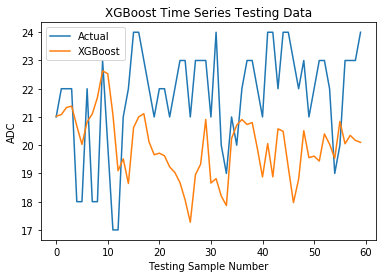

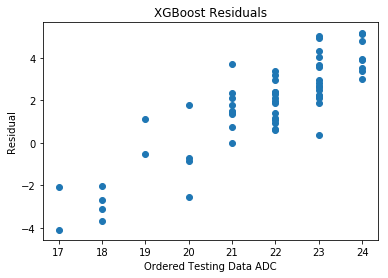

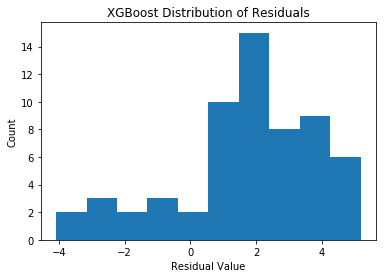

In [66]:
# predict
Y_PICU_xgb_pred = xgb_PICU_model.predict(xgb.DMatrix(X_PICU_xgb_test))
# error
PICU_xgb_res = Y_PICU_xgb_test-Y_PICU_xgb_pred
plot_test_eval(Y_PICU_xgb_test,Y_PICU_xgb_pred,PICU_xgb_res,"XGBoost")

Although the error is higher than desired, the XGBoost model is the only model thus far to realize the trends underlying the ADC patterns. Each upward and downward trend in the actual time series is met with a similar trend in the predicted series.
<br>Our XGBoost model tends to underestimate, shown by the density of our errors located above zero. However, the time series shows adaptability and may be useful in showing how patient volume changes by the day as well as by the month. If our error can be minimized this model is definitely our choice for production.

### GRU

In [34]:
# setup target variable
rnn_forecast_size = 30
Y_temp_seq_train = seq_split(Y_PICU_train,window_size=rnn_forecast_size)
Y_temp_seq_test = seq_split(Y_PICU_test,window_size=rnn_forecast_size)
#reshape outputs
Y_PICU_train_rnn = np.reshape(Y_temp_seq_train.values,(Y_temp_seq_train.shape[0],1,Y_temp_seq_train.shape[1]))
Y_PICU_test_rnn = np.reshape(Y_temp_seq_test.values,(Y_temp_seq_test.shape[0],1,Y_temp_seq_test.shape[1]))
X_PICU_train_rnn = X_PICU_train[:-rnn_forecast_size]
X_PICU_test_rnn = X_PICU_test[:-rnn_forecast_size]

In [35]:
gru = Sequential()
gru.add(GRU(64,input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
gru.add(TimeDistributed(Dense(rnn_forecast_size+1)))

# compile and fit the model
gru.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
# fit
start_time = time.time()
gru_history = gru.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=50, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=1,
                            validation_data=(X_PICU_test_rnn,Y_PICU_test_rnn)
                           )
end_time = time.time()-start_time

Train on 524 samples, validate on 23 samples
Epoch 1/50
524/524 [==============================] - 2s 3ms/step - loss: 372.7149 - mean_absolute_error: 19.0984 - val_loss: 359.4130 - val_mean_absolute_error: 18.8846
Epoch 2/50
524/524 [==============================] - 0s 317us/step - loss: 260.2751 - mean_absolute_error: 15.8794 - val_loss: 251.5180 - val_mean_absolute_error: 15.7643
Epoch 3/50
524/524 [==============================] - 0s 285us/step - loss: 175.0589 - mean_absolute_error: 12.9238 - val_loss: 172.4406 - val_mean_absolute_error: 13.0204
Epoch 4/50
524/524 [==============================] - 0s 293us/step - loss: 115.7828 - mean_absolute_error: 10.3950 - val_loss: 117.1021 - val_mean_absolute_error: 10.6906
Epoch 5/50
524/524 [==============================] - 0s 317us/step - loss: 75.3567 - mean_absolute_error: 8.2495 - val_loss: 78.4824 - val_mean_absolute_error: 8.7047
Epoch 6/50
524/524 [==============================] - 0s 333us/step - loss: 48.3928 - mean_absolute_e

Epoch 50/50
524/524 [==============================] - 0s 298us/step - loss: 6.8645 - mean_absolute_error: 2.1424 - val_loss: 4.4436 - val_mean_absolute_error: 1.8333


Training time: 10.853 seconds
Loss 4.444
Mean Absolute Error 1.833


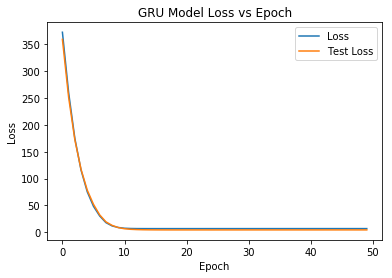

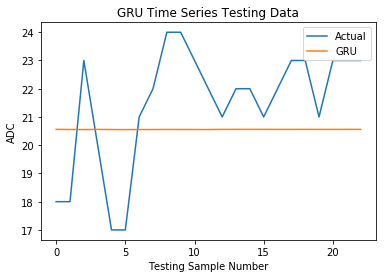

In [68]:
# show score
print("Training time: {:0.3f} seconds".format(end_time))
gru_predict = gru.predict(X_PICU_test_rnn)
gru_score = gru.evaluate(X_PICU_test_rnn,Y_PICU_test_rnn,verbose=0)
print("Loss {:0.3f}".format(gru_score[0]))
print("Mean Absolute Error {:0.3f}".format(gru_score[1]))
# plot loss
plt.plot(gru_history.history['loss'],label="Loss")
plt.plot(gru_history.history['val_loss'],label="Test Loss")
plt.title("GRU Model Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plot test series
plt.plot(Y_PICU_test_rnn[:,0,0],label='Actual')
plt.plot(gru_predict[:,0,0],label='GRU')
plt.legend()
plt.title("GRU Time Series Testing Data")
plt.ylabel("ADC")
plt.xlabel("Testing Sample Number")
plt.show()

Interestingly, our GRU model performs with the lowest error thus far on the testing data, but exhibits a constant prediction. Paired with the long training time of 10 seconds, this model does not look as promising as its error rate alone would have us believe.

### LSTM

In [69]:
lstm_1 = Sequential()
lstm_1.add(LSTM(32, input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
lstm_1.add(TimeDistributed(Dense(rnn_forecast_size+1)))

# compile and fit the model
lstm_1.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
start_time = time.time()
lstm_1_history = lstm_1.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=150, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=1,
                            validation_data=(X_PICU_test_rnn,Y_PICU_test_rnn)
                           )
end_time = time.time()-start_time

Train on 524 samples, validate on 23 samples
Epoch 1/150
524/524 [==============================] - 1s 1ms/step - loss: 409.5405 - mean_absolute_error: 20.0652 - val_loss: 439.3944 - val_mean_absolute_error: 20.9033
Epoch 2/150
524/524 [==============================] - 0s 322us/step - loss: 366.3342 - mean_absolute_error: 18.9566 - val_loss: 399.3692 - val_mean_absolute_error: 19.9230
Epoch 3/150
524/524 [==============================] - 0s 303us/step - loss: 332.0053 - mean_absolute_error: 18.0287 - val_loss: 364.7474 - val_mean_absolute_error: 19.0344
Epoch 4/150
524/524 [==============================] - 0s 299us/step - loss: 301.5147 - mean_absolute_error: 17.1625 - val_loss: 333.2607 - val_mean_absolute_error: 18.1885
Epoch 5/150
524/524 [==============================] - 0s 406us/step - loss: 273.7000 - mean_absolute_error: 16.3322 - val_loss: 304.2764 - val_mean_absolute_error: 17.3736
Epoch 6/150
524/524 [==============================] - 0s 466us/step - loss: 248.1382 - mean

Epoch 49/150
524/524 [==============================] - 0s 290us/step - loss: 6.7805 - mean_absolute_error: 2.1398 - val_loss: 4.5457 - val_mean_absolute_error: 1.8565
Epoch 50/150
524/524 [==============================] - 0s 271us/step - loss: 6.7795 - mean_absolute_error: 2.1375 - val_loss: 4.5098 - val_mean_absolute_error: 1.8479
Epoch 51/150
524/524 [==============================] - 0s 277us/step - loss: 6.7790 - mean_absolute_error: 2.1357 - val_loss: 4.4814 - val_mean_absolute_error: 1.8411
Epoch 52/150
524/524 [==============================] - 0s 297us/step - loss: 6.7789 - mean_absolute_error: 2.1343 - val_loss: 4.4588 - val_mean_absolute_error: 1.8357
Epoch 53/150
524/524 [==============================] - 0s 306us/step - loss: 6.7791 - mean_absolute_error: 2.1332 - val_loss: 4.4412 - val_mean_absolute_error: 1.8314
Epoch 54/150
524/524 [==============================] - 0s 276us/step - loss: 6.7794 - mean_absolute_error: 2.1323 - val_loss: 4.4275 - val_mean_absolute_error:

Epoch 98/150
524/524 [==============================] - 0s 312us/step - loss: 6.7981 - mean_absolute_error: 2.1324 - val_loss: 4.3981 - val_mean_absolute_error: 1.8211
Epoch 99/150
524/524 [==============================] - 0s 324us/step - loss: 6.7981 - mean_absolute_error: 2.1323 - val_loss: 4.3986 - val_mean_absolute_error: 1.8212
Epoch 100/150
524/524 [==============================] - 0s 344us/step - loss: 6.7983 - mean_absolute_error: 2.1323 - val_loss: 4.3990 - val_mean_absolute_error: 1.8214
Epoch 101/150
524/524 [==============================] - 0s 249us/step - loss: 6.7985 - mean_absolute_error: 2.1324 - val_loss: 4.3993 - val_mean_absolute_error: 1.8214
Epoch 102/150
524/524 [==============================] - 0s 457us/step - loss: 6.7989 - mean_absolute_error: 2.1325 - val_loss: 4.3991 - val_mean_absolute_error: 1.8214
Epoch 103/150
524/524 [==============================] - 0s 400us/step - loss: 6.7989 - mean_absolute_error: 2.1325 - val_loss: 4.3992 - val_mean_absolute_er

524/524 [==============================] - 0s 348us/step - loss: 6.8013 - mean_absolute_error: 2.1328 - val_loss: 4.4018 - val_mean_absolute_error: 1.8221
Epoch 147/150
524/524 [==============================] - 0s 303us/step - loss: 6.8015 - mean_absolute_error: 2.1329 - val_loss: 4.4014 - val_mean_absolute_error: 1.8220
Epoch 148/150
524/524 [==============================] - 0s 324us/step - loss: 6.8013 - mean_absolute_error: 2.1328 - val_loss: 4.4015 - val_mean_absolute_error: 1.8220
Epoch 149/150
524/524 [==============================] - 0s 367us/step - loss: 6.8014 - mean_absolute_error: 2.1328 - val_loss: 4.4017 - val_mean_absolute_error: 1.8221
Epoch 150/150
524/524 [==============================] - 0s 315us/step - loss: 6.8018 - mean_absolute_error: 2.1330 - val_loss: 4.4010 - val_mean_absolute_error: 1.8219


Training time: 27.38 seconds
Loss 4.401
Mean Absolute Error 1.822


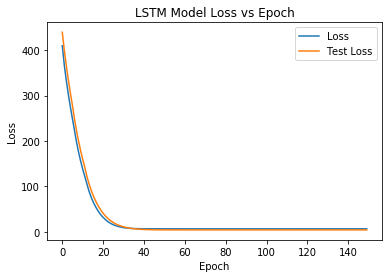

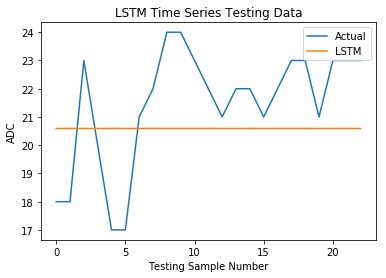

In [70]:
# show score
print("Training time: {:0.2f} seconds".format(end_time))
lstm_predict = lstm_1.predict(X_PICU_test_rnn)
lstm_1_score = lstm_1.evaluate(X_PICU_test_rnn,Y_PICU_test_rnn,verbose=0)
print("Loss {:0.3f}".format(lstm_1_score[0]))
print("Mean Absolute Error {:0.3f}".format(lstm_1_score[1]))
# plot loss
plt.plot(lstm_1_history.history['loss'],label="Loss")
plt.plot(lstm_1_history.history['val_loss'],label="Test Loss")
plt.title("LSTM Model Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
# plot test series
plt.plot(Y_PICU_test_rnn[:,0,0],label='Actual')
plt.plot(lstm_predict[:,0,0],label='LSTM')
plt.legend()
plt.title("LSTM Time Series Testing Data")
plt.ylabel("ADC")
plt.xlabel("Testing Sample Number")
plt.show()

Exactly like our GRU model above, the LSTM model performs very well in terms of error, but falls short in training time and adaptability. Both of these factors are part of our goals, so we cannot forsake adaptability for low error.

# Results
Here, we can see how each of the models performs relative to one another. First, we'll plot the testing data time series like we did above, but with all models' predictions. This will help us see where each model shines or fails. Next, we "go back in time" and run an experiment on previous months as if we were running the model in that month. This gives us a chance to see how each model might perform in production without having to wait for many months to pass. Lastly, we'll take a look at the variability in predictions and training times for each model.

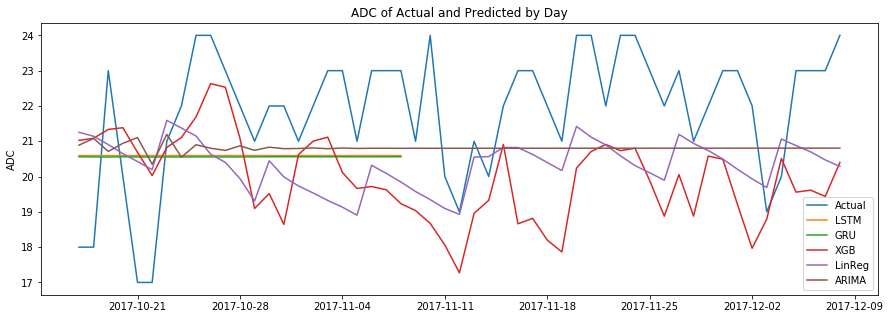

In [71]:
# show error on predicted ADC Daily
plt.figure(figsize=(15,5))
df_PICU_true = df_PICU.loc[int(len(df_PICU.index)*.66):,:]
x_eval_dates = df_PICU['EffectiveDAte'].loc[Y_PICU_test.index]
plt.plot(x_eval_dates,Y_PICU_test.values,label="Actual")
plt.plot(df_PICU['EffectiveDAte'].loc[Y_PICU_test.index[:-rnn_forecast_size]],lstm_predict[:,0,0], label="LSTM")
plt.plot(df_PICU['EffectiveDAte'].loc[Y_PICU_test.index[:-rnn_forecast_size]],gru_predict[:,0,0], label="GRU")
plt.plot(x_eval_dates,Y_PICU_xgb_pred[:len(Y_PICU_test.index)],label="XGB")
plt.plot(x_eval_dates,lr_pred[:len(Y_PICU_test.index)],label="LinReg")
plt.plot(x_eval_dates,arima_forecast[:len(Y_PICU_test.index)], label="ARIMA")
plt.title("ADC of Actual and Predicted by Day")
plt.ylabel("ADC")
plt.legend()
plt.show()

Our most stable models are our RNN models. Surprisingly, these models show no signs of adaptability throughout the testing data. Similarly, the ARIMA model appears to follow the Actual signal, but also resigns to a stable signal after only 10 days. Our linear models show the most adaptability, where our XGBoost model shows almost the exact trends with some bias.

The code below may seem verbose, but it simply streamlines each model from input to output. Essentially, it simulates the use of the model in production, namely forecasting the next month's ADC based on available data.

In [74]:
# find Monthly averages
df_PICU_true_M = df_PICU_true.groupby(by=[df_PICU_true.EffectiveDAte.dt.month]).mean()
test_months = {4:30,5:31,6:30,7:31,8:31,9:30,10:31,11:30,12:31}
start_date = '2016-03-28'
df_time_eval = pd.DataFrame()
### forecast arrays
arima_forecasts,xgb_forecasts,lr_forecasts,gru_forecasts,lstm_forecasts = [],[],[],[],[]
for test_month in list(test_months.keys())[1:]:
    # use all data up until first day of next month
    end_date = "2017-" + str(test_month-1) + "-" + str(test_months[test_month-1])
    df_PICU_curr = df_PICU[df_PICU['EffectiveDAte'].isin(pd.date_range(start = start_date,end=end_date))]
    ### train models
    # arima
    start_time = time.time()
    arima_model = ARIMA(df_PICU_curr['AverageCensusCount'], 
                      order=order
                     )
    arima_model_fit = arima_model.fit()
    arima_forecast,_,_ = arima_model_fit.forecast(steps=test_months[test_month])
    arima_forecasts.append(arima_forecast)
    df_time_eval.loc[test_month,"ARIMA"] = time.time()-start_time
    # xgb
    start_time=time.time()
    Y_PICU_curr_xgb = df_PICU_curr['AverageCensusCount']
    X_PICU_curr_xgb = X_PICU_xgb[df_PICU_xgb["EffectiveDAte"].isin(pd.date_range(start=start_date,end=end_date))]
    next_month = pd.date_range(start=end_date,end="2017-" + str(test_month) + "-" + str(test_months[test_month]))
    X_PICU_pred_xgb = X_PICU_xgb[df_PICU_xgb["EffectiveDAte"].isin(next_month)]
    xgb_PICU_model = xgb.train(params, xgb.DMatrix(X_PICU_curr_xgb,label=Y_PICU_curr_xgb), num_boost_round=100)
    xgb_forecasts.append(xgb_PICU_model.predict(xgb.DMatrix(X_PICU_pred_xgb)))
    df_time_eval.loc[test_month,"XGB"] = time.time()-start_time
    # Linear Regression
    start_time=time.time()
    lr_model = LinearRegression()
    lr_model.fit(X_PICU_curr_xgb.fillna(0),Y_PICU_curr_xgb)
    lr_forecasts.append(lr_model.predict(X_PICU_pred_xgb.fillna(0)))
    df_time_eval.loc[test_month,"LinReg"] = time.time()-start_time
    # GRU / LSTM
    df_seq_train = seq_split(df_PICU_curr['AverageCensusCount'],window_size=window_size)
    X_PICU_train_rnn_temp = df_seq_train.iloc[:,:-1]
    Y_PICU_train_rnn_temp = df_seq_train.iloc[:,-1]
    # reshape for LSTM
    X_PICU_train_rnn = np.reshape(X_PICU_train_rnn_temp.values, (len(X_PICU_train_rnn_temp), 1, X_PICU_train_rnn_temp.shape[1]))
    rnn_forecast_size = test_months[test_month]
    Y_seq_train = seq_split(Y_PICU_train_rnn_temp,window_size=rnn_forecast_size)
    #reshape outputs
    Y_PICU_train_rnn = np.reshape(Y_seq_train.values,(Y_seq_train.shape[0],1,Y_seq_train.shape[1]))
    Y_PICU_train_rnn = Y_PICU_train_rnn[:-1]
    X_PICU_train_rnn = X_PICU_train_rnn[:-(rnn_forecast_size+1)]
    X_PICU_test_rnn = X_PICU_train_rnn[-1]
    X_PICU_test_rnn = np.reshape(X_PICU_test_rnn,(X_PICU_test_rnn.shape[0],1,X_PICU_test_rnn.shape[1]))
    # train models
    # gru
    start_time = time.time()
    gru = Sequential()
    gru.add(GRU(64,input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
    gru.add(TimeDistributed(Dense(rnn_forecast_size+1)))
    gru.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
    gru_history = gru.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=50, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=0
                           )
    df_time_eval.loc[test_month,"GRU"] = time.time()-start_time
    # lstm
    start_time=time.time()
    lstm_1 = Sequential()
    lstm_1.add(LSTM(32, input_shape=(X_PICU_train_rnn.shape[1],X_PICU_train_rnn.shape[2]),return_sequences=True))
    lstm_1.add(TimeDistributed(Dense(rnn_forecast_size+1)))
    lstm_1.compile(loss='mean_squared_error', 
               optimizer='adam',
               metrics=['mae'])
    lstm_1_history = lstm_1.fit(X_PICU_train_rnn, Y_PICU_train_rnn, 
                            epochs=150, 
                            batch_size=8, 
                            shuffle=False,
                            verbose=0
                           )
    df_time_eval.loc[test_month,"LSTM"] = time.time()-start_time
    # predict
    gru_forecasts.append(gru.predict(X_PICU_test_rnn))
    lstm_forecasts.append(lstm_1.predict(X_PICU_test_rnn))
# average each month and add to results df
arima_forecasts_means=[]
xgb_forecasts_means = []
lr_forecasts_means = []
gru_forecasts_means = []
lstm_forecasts_means= []
for month in range(len(arima_forecasts)):
    arima_forecasts_means.append(np.mean(arima_forecasts[month]))
    xgb_forecasts_means.append(np.mean(xgb_forecasts[month]))
    lr_forecasts_means.append(np.mean(lr_forecasts[month]))
    gru_forecasts_means.append(np.mean(gru_forecasts[month]))
    lstm_forecasts_means.append(np.mean(lstm_forecasts[month]))
df_PICU_true_M['ARIMA'] = arima_forecasts_means
df_PICU_true_M['XGBoost'] = xgb_forecasts_means
df_PICU_true_M['Linear Regression'] = lr_forecasts_means
df_PICU_true_M['GRU'] = gru_forecasts_means
df_PICU_true_M['LSTM'] = lstm_forecasts_means

/home/conner/.local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


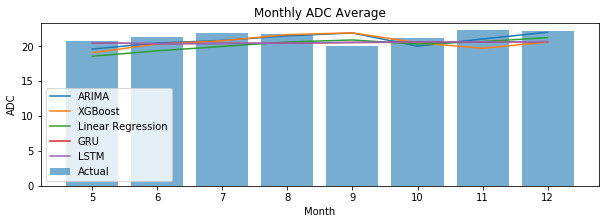

Target (Under 15% MAPE)	 3.209
ARIMA	 0.956 +/- 0.565
XGBoost	 1.308 +/- 0.765
LinReg	 1.425 +/- 0.535
GRU	 1.024 +/- 0.544
LSTM	 1.023 +/- 0.537


Average Training Time in seconds


ARIMA      2.793283
XGB        0.115379
LinReg     0.001510
GRU        9.562463
LSTM      23.730989
dtype: float64

In [77]:
# show averaged monthly ADC
plt.figure(figsize=(10,3))
plt.bar(df_PICU_true_M.index,df_PICU_true_M['AverageCensusCount'],label="Actual",alpha=.6)
plt.plot(df_PICU_true_M.index,df_PICU_true_M['ARIMA'],label="ARIMA")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['XGBoost'],label="XGBoost")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['Linear Regression'],label="Linear Regression")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['GRU'],label="GRU")
plt.plot(df_PICU_true_M.index,df_PICU_true_M['LSTM'],label="LSTM")
plt.title("Monthly ADC Average")
plt.ylabel("ADC")
plt.xlabel("Month")
plt.legend()
plt.show()
# error metrics
arima_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['ARIMA'])
xgb_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['XGBoost'])
lr_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['Linear Regression'])
gru_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['GRU'])
lstm_error = abs(df_PICU_true_M['AverageCensusCount'] - df_PICU_true_M['LSTM'])
print("Target (Under 15% MAPE)\t {:0.3f}".format(0.15 * df_PICU_true_M['AverageCensusCount'].mean()))
print("ARIMA\t {:0.3f} +/- {:0.3f}".format(arima_error.mean(),arima_error.std()))
print("XGBoost\t {:0.3f} +/- {:0.3f}".format(xgb_error.mean(),xgb_error.std()))
print("LinReg\t {:0.3f} +/- {:0.3f}".format(lr_error.mean(),lr_error.std()))
print("GRU\t {:0.3f} +/- {:0.3f}".format(gru_error.mean(),gru_error.std()))
print("LSTM\t {:0.3f} +/- {:0.3f}".format(lstm_error.mean(),lstm_error.std()))
# training time
print("\n\nAverage Training Time in seconds")
display(df_time_eval.mean())

# Evaluation
From the errors, we can see that each model performs within our requirements. There are obviously models which perform best, but at the cost of predictive power. If we were solely tasked with predicting the monthly ADC with the lowest error then we could choose LSTM and productionize it. However, we are also looking to give nursing managers an idea of how the ADC will change throughout the month, giving them the ability to adapt their nursing needs to the number of patients their department will see. The most adaptable model, XGBoost, clearly mirrors the actual ADC activity throughout the month. From this, nursing managers will also be informed of excessively high or low ADC ahead of time. Ultimately, the ability to adapt nursing staff schedules to the number of patients is what will drive more efficient work and costs.